In [10]:
import sys
model_dir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models'
sys.path.append(model_dir )
sys.path.append(model_dir+'/modules')
sys.path.append(model_dir+'/data')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
import sys
sys.path.insert(0, './modules/')
from modules import data_analysis_tools as dat
from plottingtools import  *
from numpy.linalg import eigvals
from numpy.random import choice
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
from scipy.stats import gaussian_kde
from RecurrentNets import *
# import mpl_scatter_density
import scipy.stats as stats
plt.rcParams.update({
    "text.usetex": False})
figsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/final_fig_panels/ED_Fig7/'

In [11]:
# Set up decoding accuracy model with inputs to E and I

n = 120 # fine grain ness of model (was 120)
S_EE = 0
S_EI = 2
S_IE = 2
S_II = 0.

D_EE = S_EE
D_EI = linspace(-S_EI, S_EI, n)
D_IE = linspace(-S_IE, S_IE, n)
D_II = 0.


selectivity_E1    = empty((len(D_IE),len(D_EI)))
selectivity_E2    = empty((len(D_IE),len(D_EI)))
selectivity_I1    = empty((len(D_IE),len(D_EI)))
selectivity_I2    = empty((len(D_IE),len(D_EI)))
decodacc_E     = empty((len(D_IE),len(D_EI)))
decodacc_EI    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh = empty((len(D_IE),len(D_EI)))

selectivity_E1_0    = empty((len(D_IE),len(D_EI)))
selectivity_E2_0    = empty((len(D_IE),len(D_EI)))
selectivity_I1_0    = empty((len(D_IE),len(D_EI)))
selectivity_I2_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh_0  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh_0 = empty((len(D_IE),len(D_EI)))

amplification = empty((len(D_IE),len(D_EI)))
suppression = empty((len(D_IE),len(D_EI)))

N = 4
sigma_input = 0
sigma_obs = 1
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_sh[i_IE, i_EI]  = nan
            decodacc_E_sh[i_IE, i_EI]   = nan

        else:
            # set connectivity matrix
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            alpha = 1-S_EE+S_EI*S_IE
            delta = 1-D_EE+D_EI[i_EI]*D_IE[i_IE]

            amplification[i_IE, i_EI] = (1/alpha+1/delta)/2
            suppression[i_IE, i_EI] = (1/alpha-1/delta)/2

            J    = block([[Win, Wout], [Wout, Win]])
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,1,0,0])
            dh2 = array([0,0,1,1])
            dh = dh1 - dh2

            cov = sigma_obs * eye(N)
            decodacc_EI[i_IE, i_EI], decodacc_EI_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI], decodacc_E_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0, 2])
            # selectivity_E1[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], decodacc_EI_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI], decodacc_E_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
            # selectivity_E1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

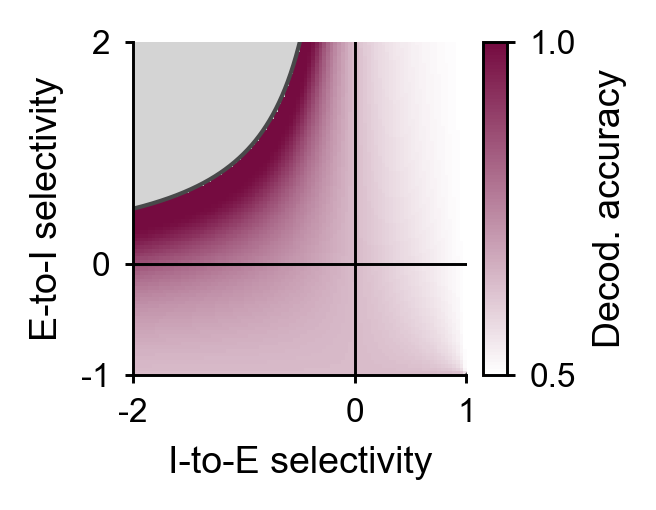

In [12]:
# Ext Data Fig. 9a
# Decoding accuracy phase plot
# The phase plots are computed assuming equal selective inputs on E and I neurons
# The phase plots are restricted to the regions where both the following conditions hold:
# 1) E neurons are selective for the stimulus for which they receive higher external input
# 2) I neurons are selective for the stimulus for which they receive higher external input


DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

#fig,ax = my_figure(figsize=(2.4,1.9))
fig,ax = my_figure(figsize=(2.5,1.8))
colors = ['w','#750b40']
cm = define_colormap(colors,100)
Z = decodacc_E

Z[delta<0] = nan
Z[DD_EI>1] = nan
Z[DD_IE<-1] = nan
cm.set_bad(color='#d4d4d4')
clim = (0.5,1)
c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')


x1 = linspace(-2,(D_EE-1)/2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')

x1 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')

xlim = (-2,2)
ylim = (0,2)

xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[-S_IE,S_IE],'-',color='k', lw=.7)
plot([-S_EI,S_EI],[0,0],'-',color='k', lw=.7)

#cbar = fig.colorbar(c, ticks=(0.5,1), fraction=0.025).set_label('Decod. \n accuracy')
# Put colorbar on right
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
cax = ax_divider.append_axes("right", size="7%", pad="5%")
cb = fig.colorbar(c, cax=cax, orientation="vertical",ticks=(0.5,1)).set_label('Decod. accuracy')
#cax.xaxis.set_ticks_position("top")
#cax.xaxis.set_label_position("top")

'''
# Put colorbar on top
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
cax = ax_divider.append_axes("top", size="10%", pad="10%")
cb = fig.colorbar(c, cax=cax, orientation="horizontal",ticks=(0.5,1)).set_label('Decod. accuracy')
#cax.xaxis.set_ticks_position("top")
#cax.xaxis.set_label_position("top")
'''
ax.set_xlim([-2,+1])
ax.set_xticks([-2,0,+1])
ax.set_ylim([-1,+2])
ax.set_yticks([-1,0,+2])

tight_layout()
#plt.savefig(figsDir+'decod_acc_phaseplot_inputEI.pdf',bbox_inches='tight')

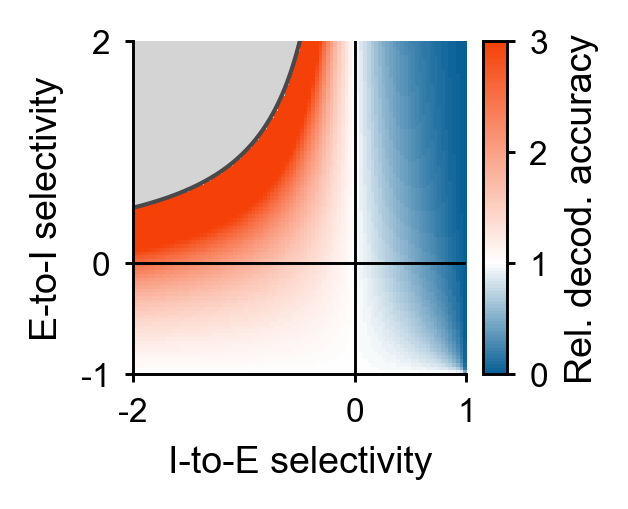

In [13]:
# Ext. Data Fig. 9b
# Relative decoding accuracy phase plot
# The phase plots are computed assuming equal selective inputs on E and I neurons
# The phase plots are restricted to the regions where both the following conditions hold:
# 1) E neurons are selective for the stimulus for which they receive higher external input
# 2) I neurons are selective for the stimulus for which they receive higher external input

DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

fig,ax = my_figure(figsize=(2.5,1.8))
colors = ['#086096','w','#faa186','#f54108']
cm = define_colormap(colors,100)

Z = abs((decodacc_E-0.5)/(decodacc_E_0-0.5))

Z[delta<0] = nan
Z[DD_EI>1] = nan
Z[DD_IE<-1] = nan
cm.set_bad(color='#d4d4d4')

clim = (0,3)
c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')

x1 = linspace(-2,(D_EE-1)/2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')

x1 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')

xlim = (-2,2)
ylim = (0,2)

xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[-S_IE,S_IE],'-',color='k', lw=.7)
plot([-S_EI,S_EI],[0,0],'-',color='k', lw=.7)
tight_layout()

# Put colorbar on right
#cbar = fig.colorbar(c, ticks=(0,1,2,3), fraction=0.025).set_label('Rel. decod. \n accuracy')
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
cax = ax_divider.append_axes("right", size="7%", pad="5%")
cb = fig.colorbar(c, cax=cax, orientation="vertical",ticks=(0,1,2,3)).set_label('Rel. decod. accuracy')
#ax.set_xticks([-2,0,+2])
#ax.set_yticks([-2,0,+2])

ax.set_xlim([-2,+1])
ax.set_xticks([-2,0,+1])
ax.set_ylim([-1,+2])
ax.set_yticks([-1,0,+2])
plt.savefig(figsDir+'decod_acc_normalized_phaseplot_inputEI.pdf',bbox_inches='tight', dpi=300)

In [2]:
net_list = load(model_dir+'/data/appeal/randIn/n131/net_list_EI.npy')
results_corr_IE, results_corr_EI = load(model_dir+'/data/appeal/randIn/n131/CorrelationsViolin_inputEI.npy')

Number of nets = (164,), (164,)
Ttest_1sampResult(statistic=11.290366581856503, pvalue=3.3186863517947873e-22)
Ttest_1sampResult(statistic=-29.38511985356421, pvalue=5.015065173604677e-67)


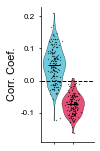

In [3]:
# Fig ED 9c: sel across networks
i_par = 0
color_points = ['k','k']
color_bodies = ['#6ec9db', '#e85177']

fig = figure(figsize=(1.5,2.2))
ax = fig.add_subplot(111)
format_axes(ax,'0')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
positions=[1,2]
widths=[1.2,1.2]
data1 = results_corr_IE[i_par]
data2 = results_corr_EI[i_par]
data1 = data1[~isnan(data1)]
data2 = data2[~isnan(data2)]
data = [data1, data2]
parts = ax.violinplot(data, positions=positions, widths=widths, showmedians=True, showextrema=False)
for i in range(len(data)):
    for j in range(len(data[i])):
        plot([positions[i]+random.normal(0,0.15)], [data[i][j]], '.', markersize=0.5, alpha=1, color=color_points[i])

i=0
for pc in parts['bodies']:
    pc.set_facecolor(color_bodies[i])
    pc.set_edgecolor('black')
    pc.set_linewidth(0.3)
    pc.set_alpha(1)
    i+=1
parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(1)
xticks([1,2],['E-to-I', 'I-to-E'])
#plt.xticks(rotation = 45)
xticks([1,2],[])
#ax.spines['bottom'].set_bounds(1,2)
#ax.spines['left'].set_bounds(-0.05,0.1)
ax.set_ylabel('Corr. Coef.', fontsize = 11)
xlim = ax.get_xlim()

ax.set_xlim([xlim[0],xlim[1]+.4])
xlim = ax.get_xlim()

ax.plot(xlim, [0,0], '--', lw=1, color='k')
ylim = ax.get_ylim()
ax.set_ylim([ylim[0]-.01, ylim[1]])
tight_layout()

print(f'Number of nets = {data1.shape}, {data2.shape}')
print(stats.ttest_1samp(data[0], 0, axis=0, nan_policy='propagate', alternative='two-sided'))
print(stats.ttest_1samp(data[1], 0, axis=0, nan_policy='propagate', alternative='two-sided'))

#plt.savefig(figsDir+'ED9c_sel_across_nets.pdf',bbox_inches='tight')

In [4]:
# Setup perturbations

f = model_dir+'/data/appeal/randIn/n131/perturbations_131_inputEI_1_pt3_cut.pkl'
df = pd.read_pickle(f)


n_nets = int(len(df['data'][0]))
par = df['psparse'].values
n_par = len(par)
n = len(df['data'][0][0]['R2_IE'])

R2_IE = np.nan*np.ones((n_par,n_nets,n))
R2_EI = np.nan*np.ones((n_par,n_nets,n))
dist_orig = np.nan*np.ones((n_par,n_nets,n))
dist_pert_EI = np.nan*np.ones((n_par,n_nets,n))
dist_pert_IE = np.nan*np.ones((n_par,n_nets,n))
acc_pert_EI = np.nan*np.ones((n_par,n_nets,n))
acc_pert_IE = np.nan*np.ones((n_par,n_nets,n))
D_EI = np.nan*np.ones((n_par,n_nets,n))
D_IE = np.nan*np.ones((n_par,n_nets,n))

for i_par in range(len(df)):
    print(i_par)
    n_nets_notnan = 0
    for i_net in range(n_nets):
        data = df['data'][i_par][i_net]
        if i_net not in net_list:
            continue
        n_nets_notnan += 1
        R2_IE[i_par, i_net, :] = data['R2_IE']
        R2_EI[i_par, i_net, :] = data['R2_EI']
        dist_orig[i_par, i_net, :] = data['dist_orig']
        dist_pert_EI[i_par, i_net, :] = data['dist_pert_EI']
        dist_pert_IE[i_par, i_net, :] = data['dist_pert_IE']
        D_EI[i_par, i_net, :] = data['D_EI']
        D_IE[i_par, i_net, :] = data['D_IE']

print('Number of nets = ', n_nets_notnan)

0
Number of nets =  164


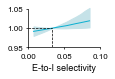

In [5]:
# ED Fig. 9d top: E-to-I
central_idx = 4

i_par = 0

# fig = figure(figsize=(1.8,1.8))
fig = figure(figsize=(1.7,1.2))
ax = fig.add_subplot(1,1,1)
# format_axes(ax,'2')

Z = D_IE[i_par,:,:]
X = Z
condition1 = ~np.isnan(X).any(axis=1)
X = X[condition1, :]
xvals = mean(X,axis=0)

Z = dist_pert_IE[i_par,:,:]
X = Z/tile(Z[:,central_idx][:,None],(1,n))
X = X[condition1, :]

# the current code plots the 25,75 percentiles across nets, 
# alternatively you can bootstrap the median across nets --> the errorbars would be much smaller,
# hardly visible in a tiny fig)
# X = bootstrap_median(X, n_boot=100) 

P = nanpercentile(X, [25, 75], axis=0)
m = nanmedian(X, axis=0)
s1,s2 = m-P[0], P[1]-m
ax.fill_between(xvals, m-s1, m+s2, color='#c5e2e8')
ax.plot(xvals, m, '-', lw=1., markersize=4, color='#0db0d1')
# errorbar(xvals, m, yerr=[s1,s2], fmt='.-', lw=1., markersize=4, color='#0db0d1')

# ax.plot(x, median(X, axis=0), '.-', lw=1., markersize=5, color='#0db0d1')
ax.spines['left'].set_bounds(0.95,1.05)
ax.spines['bottom'].set_bounds(0.0,0.1)
ax.set_xlabel('E-to-I selectivity')
#ax.set_ylabel('Rel. dist.')

plt.xlim(-0.0,0.1)
plt.ylim(0.95,1.055)
# xticks([.05, .1, 0.15], ['0.05', '0.1', '0.15'])
yticks([0.95, 1,1.05])

ax.plot([ax.get_xlim()[0],xvals[central_idx]], [1,1], '--', lw=0.7, color='k')

ylim1 = ax.get_ylim()[0]
ax.plot([xvals[central_idx],xvals[central_idx]],[ylim1,median(X, axis=0)[central_idx]], '--', lw=0.7, color='k')
tight_layout()
#plt.savefig(figsDir+'ED9d_top_perturb_IE.pdf',bbox_inches='tight')

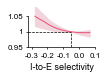

In [6]:
# ED Fig. 9d bottom: I-to-E
central_idx = 8

# fig = figure(figsize=(1.8,1.8))
fig = figure(figsize=(1.6,1.2))
ax = fig.add_subplot(1,1,1)
format_axes(ax,'1','1')

Z = D_EI[i_par,:,:]
X = Z
condition1 = ~np.isnan(X).any(axis=1)
X = X[condition1, :]
xvals = nanmean(X,axis=0)

Z = dist_pert_EI[i_par,:,:]
X = Z/tile(Z[:,central_idx][:,None],(1,n))
X = X[condition1, :]

# the current code plots the 25,75 percentiles across nets, 
# alternatively you can bootstrap the median across nets --> the errorbars would be much smaller,
# hardly visible in a tiny fig)
# X = bootstrap_median(X, n_boot=100) 

P = nanpercentile(X, [25, 75], axis=0)
m = nanmedian(X, axis=0)
s1,s2 = m-P[0], P[1]-m
ax.fill_between(xvals, m-s1, m+s2, color='#f2d5dc')
ax.plot(xvals, m, '-', lw=1., markersize=4, color='#e85177')
# errorbar(xvals, m, yerr=[s1,s2], fmt='.-', lw=1., markersize=4, color='#e85177')

ax.spines['left'].set_bounds(0.95,1.05)
#ax.spines['bottom'].set_bounds(-0.2,0.1)
#ax.set_xlabel('I-to-E connect. \nselectivity')
ax.set_xlabel('I-to-E selectivity')
#ax.set_ylabel('Rel. dist.')
#plt.title('I-to-E')

plt.xlim(-0.32,0.1)
#plt.xlim(-0.2,0.1)
xticks([-0.3,-0.2,-.1, 0, .1])#, ['''-0.2', '-0.1', '0', '0.1'])
plt.ylim(0.95,1.08)
yticks([0.95,1,1.05],['0.95','1','1.05'])
ax.set_yticks([0.95,1,1.05])
#yticks([1])
# yticks([0.8,1,1.2])

ax.plot([ax.get_xlim()[0],xvals[central_idx]], [1,1], '--', lw=0.7, color='k')
ylim1 = ax.get_ylim()[0]
ax.plot([xvals[central_idx],xvals[central_idx]],[ylim1,nanmedian(X, axis=0)[central_idx]], '--', lw=0.7, color='k')
tight_layout()
plt.savefig(figsDir+'ED9d_bottom_perturb_IE.pdf',bbox_inches='tight')